In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

# style.use('seaborn-v0_8-whitegrid')
from IPython.display import display

model_names = [
    'transformer',
    'resnet18',
    'resnet50'
    ]

# set this to be the same as the one in the experiment
model_idx = 0
batch_size = 64
model = model_names[model_idx]

data_file_pre = f'out/{model}_{batch_size}_pre.csv'
data_file_post = f'out/{model}_{batch_size}_post.csv'

df_pre = pd.read_csv(data_file_pre)
df_post = pd.read_csv(data_file_post)

df = df_post

name_to_rank = {}
for _, row in df.iterrows():
    name_to_rank[row['name']] = row['rank']

df['type'].value_counts()
display(df.head())
display(df['type'].value_counts())

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],{},131072.0,131072.0,0.023808,NodeType.OTHER,9647104,9647104,9647104,NaN,NaN,NaN,NaN,NaN
1,1,arg0_2,placeholder,arg0_2,[],"{embedding_1: None, _foreach_addcdiv: None, co...",16384.0,16384.0,0.018816,NodeType.PARAM,9647104,9647104,9647104,embedding_1,embedding_1,_foreach_addcdiv,copy__1213,copy__1213
2,2,arg0_3,placeholder,arg0_3,[],"{native_layer_norm: None, mul_113: None, _fore...",64.0,64.0,0.018176,NodeType.PARAM,9647104,9647104,9647104,native_layer_norm,native_layer_norm,mul_113,copy__1214,copy__1214
3,3,arg0_4,placeholder,arg0_4,[],"{native_layer_norm: None, _foreach_addcdiv: No...",64.0,64.0,0.018048,NodeType.PARAM,9647104,9647104,9647104,native_layer_norm,native_layer_norm,_foreach_addcdiv,copy__1215,copy__1215
4,4,arg0_5,placeholder,arg0_5,[],"{t: None, _foreach_addcdiv: None, copy__1216: ...",1024.0,1024.0,0.018048,NodeType.PARAM,9647104,9647104,9647104,t,t,_foreach_addcdiv,copy__1216,copy__1216


NodeType.OTHER                3257
NodeType.GRAD_INTERMEDIATE     741
NodeType.ACT                   235
NodeType.ACT_DISCARD           219
NodeType.PARAM                 100
NodeType.GRAD                  100
Name: type, dtype: int64

In [95]:
# some preprocessing
df['mem_cuda_GB'] = df.mem_cuda * 1e-9
df['mem_cuda_pre_GB'] = df.mem_cuda_pre * 1e-9
df['mem_cuda_peak_GB'] = df.mem_cuda_peak * 1e-9


op_start = df[df.op == 'call_function']['rank'].min()
sep_rank = df[df.name == 'sep']['rank'].item()
sep_back_rank = df[df.name == 'sep_backward']['rank'].item()
opt_start = df[df.name == '_foreach_lerp_']['rank'].item()

print(op_start, sep_rank, sep_back_rank, opt_start)

df_grad = df[:opt_start]
df_grad[op_start:].head()

408 861 864 1908


,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,...,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use,mem_cuda_GB,mem_cuda_pre_GB,mem_cuda_peak_GB
408,408,embedding,call_function,aten.embedding.default,"[arg0_101, arg3_3]",{add: None},1048576.0,1048576.0,0.224256,NodeType.ACT_DISCARD,...,10695680,10695680,add,add,NaN,NaN,add,0.010696,0.010696,0.010696
409,409,arange,call_function,aten.arange.start,[],"{embedding_1: None, embedding_dense_backward: ...",2048.0,2048.0,0.073344,NodeType.ACT,...,10697728,10697728,embedding_1,embedding_1,embedding_dense_backward,embedding_dense_backward,embedding_dense_backward,0.010698,0.010698,0.010698
410,410,embedding_1,call_function,aten.embedding.default,"[arg0_2, arange]",{add: None},16384.0,16384.0,0.054272,NodeType.ACT_DISCARD,...,10714112,10714112,add,add,NaN,NaN,add,0.010714,0.010714,0.010714
411,411,add,call_function,aten.add.Tensor,"[embedding, embedding_1]",{native_dropout: None},1048576.0,1048576.0,0.053504,NodeType.ACT_DISCARD,...,11762688,11762688,native_dropout,native_dropout,NaN,NaN,native_dropout,0.011763,0.011763,0.011763
412,412,native_dropout,call_function,aten.native_dropout.default,[add],"{getitem: None, getitem_1: None}",1310720.0,1310720.0,0.056576,NodeType.ACT_DISCARD,...,12008448,12008448,getitem,getitem_1,NaN,NaN,getitem_1,0.012008,0.012008,0.012008


In [96]:
# make sure to give a minimum allocation size
# DOES NOT CHANGE ANYTHING
df['size'] = df['size'].where(df['size'] > 512, 512)

In [97]:
# compute memory usage here

memory_usage = np.zeros(df.shape[0])

for _, row in df.iterrows():

    start = row['rank']
    if row['op'] == 'placeholder':
        start = 0
    end = df.shape[0]

    if not pd.isna(row['last_use']):
        end = name_to_rank[row['last_use']]

    memory_usage[start:end] += row['size']

memory_usage

array([1522176., 1522176., 1522176., ..., 1391616., 1260544.,  395776.])

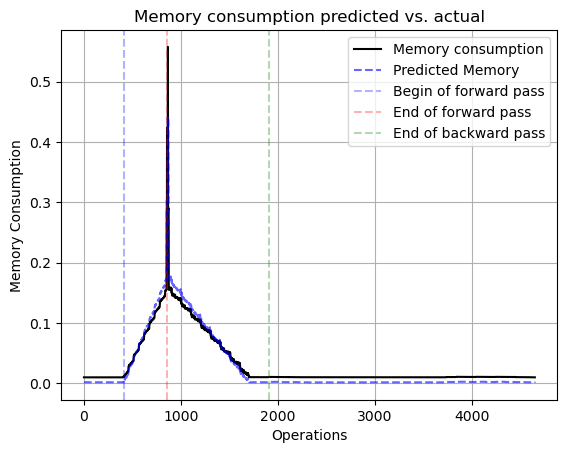

In [98]:
plt.grid()
plt.plot(df.mem_cuda_GB, color = 'k', label='Memory consumption')
plt.plot(memory_usage/1e9, color='b', linestyle='--', alpha=0.6, label='Predicted Memory')

plt.title('Memory consumption predicted vs. actual')
plt.xlabel('Operations')
plt.ylabel('Memory Consumption')

plt.axvline(op_start, color='b', linestyle='--', alpha=0.3, label='Begin of forward pass')
plt.axvline(sep_rank, color='r', linestyle='--', alpha=0.3, label='End of forward pass')
plt.axvline(opt_start, color='g', linestyle='--', alpha=0.3, label = 'End of backward pass')
plt.legend()
plt.savefig(f'figs/memory_prediction_{model}.png')
plt.show()

In [93]:
# import torch
# model_true = torch.load('model_True.pt')
# model_false = torch.load('model_False.pt')

In [79]:
# keys = model_true.state_dict()
# closeness = []
# for p in keys:
#     if not torch.allclose(model_true.state_dict()[p], model_false.state_dict()[p]):
#         print(p)
